## Installations

In [1]:
!pip3 install langdetect
!pip3 install contractions
!pip3 install --upgrade emoji
!pip3 install nltk
!pip3 install imblearn
!pip3 install h5py
!pip3 install torch
!pip3 install transformers
!pip3 install tqdm
!pip3 install --upgrade seaborn

## Import libraries

In [2]:
# Libraries for general purpose
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Text cleaning
import re
import string
import emoji
import nltk
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords

# Data preprocessing
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from langdetect import detect, LangDetectException
import contractions
from nltk.tokenize import word_tokenize

# Pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Transformers library for BERT
import transformers
from transformers import BertModel
from transformers import BertTokenizer
from transformers import AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import classification_report, confusion_matrix

import time

In [3]:
!pip3 install --upgrade seaborn

In [4]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [5]:
# Set seed for reproducibility
import random
seed_value = 2042
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)

# Set style for plots
sns.set_style("whitegrid")
sns.despine()
plt.rc("figure", autolayout=True)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlepad=10)

# Define stop words for text cleaning
stop_words = set(stopwords.words('english'))

# Initialize lemmatizer for text cleaning
lemmatizer = WordNetLemmatizer()

<Figure size 640x480 with 0 Axes>

# Dataset

In [6]:
#Import Dataset
df = pd.read_csv('cyberbullying_tweets.csv')

In [7]:
df.head()

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47692 entries, 0 to 47691
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_text          47692 non-null  object
 1   cyberbullying_type  47692 non-null  object
dtypes: object(2)
memory usage: 745.3+ KB


In [9]:
#Rename the columns using shorter words for easier reference.
df = df.rename(columns={'tweet_text': 'text', 'cyberbullying_type': 'label'})

In [10]:
#Check for duplicates
df.duplicated().sum()

36

In [11]:
#removing duplicates
df = df[~df.duplicated()]

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47656 entries, 0 to 47691
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    47656 non-null  object
 1   label   47656 non-null  object
dtypes: object(2)
memory usage: 1.1+ MB


In [13]:
#check class balance 
df.label.value_counts()

label
religion               7997
age                    7992
ethnicity              7959
gender                 7948
not_cyberbullying      7937
other_cyberbullying    7823
Name: count, dtype: int64

The classes look balanced.

# Data Cleaning

In [14]:
# Clean emojis from text
def strip_emoji(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # Emoticons
                               u"\U0001F300-\U0001F5FF"  # Symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # Transport & map symbols
                               u"\U0001F700-\U0001F77F"  # Alphanumeric characters
                               u"\U0001F780-\U0001F7FF"  # Geometric shapes
                               u"\U0001F800-\U0001F8FF"  # Miscellaneous symbols
                               u"\U0001F900-\U0001F9FF"  # Supplemental symbols and pictographs
                               u"\U0001FA00-\U0001FA6F"  # Extended-A
                               u"\U0001FA70-\U0001FAFF"  # Extended-B
                               u"\U00002702-\U000027B0"  # Dingbats
                               u"\U000024C2-\U0001F251" 
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

# Remove punctuations, stopwords, links, mentions and new line characters
def strip_all_entities(text):
    text = re.sub(r'\r|\n', ' ', text.lower())  # Replace newline and carriage return with space, and convert to lowercase
    text = re.sub(r"(?:\@|https?\://)\S+", "", text)  # Remove links and mentions
    text = re.sub(r'[^\x00-\x7f]', '', text)  # Remove non-ASCII characters
    banned_list = string.punctuation
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    text = ' '.join(word for word in text.split() if word not in stop_words)
    return text

# Clean hashtags at the end of the sentence, and keep those in the middle of the sentence by removing just the # symbol
def clean_hashtags(tweet):
    # Remove hashtags at the end of the sentence
    new_tweet = re.sub(r'(\s+#[\w-]+)+\s*$', '', tweet).strip()
    
    # Remove the # symbol from hashtags in the middle of the sentence
    new_tweet = re.sub(r'#([\w-]+)', r'\1', new_tweet).strip()
    
    return new_tweet

# Filter special characters such as & and $ present in some words
def filter_chars(text):
    return ' '.join('' if ('$' in word) or ('&' in word) else word for word in text.split())

# Remove multiple spaces
def remove_mult_spaces(text):
    return re.sub(r"\s\s+", " ", text)

# Function to check if the text is in English, and return an empty string if it's not
def filter_non_english(text):
    try:
        lang = detect(text)
    except LangDetectException:
        lang = "unknown"
    return text if lang == "en" else ""

# Expand contractions
def expand_contractions(text):
    return contractions.fix(text)

# Remove numbers
def remove_numbers(text):
    return re.sub(r'\d+', '', text)

# Lemmatize words
def lemmatize(text):
    words = word_tokenize(text)
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(lemmatized_words)

# Remove short words
def remove_short_words(text, min_len=2):
    words = text.split()
    long_words = [word for word in words if len(word) >= min_len]
    return ' '.join(long_words)

# Replace elongated words with their base form
def replace_elongated_words(text):
    regex_pattern = r'\b(\w+)((\w)\3{2,})(\w*)\b'
    return re.sub(regex_pattern, r'\1\3\4', text)

# Remove repeated punctuation
def remove_repeated_punctuation(text):
    return re.sub(r'[\?\.\!]+(?=[\?\.\!])', '', text)

# Remove extra whitespace
def remove_extra_whitespace(text):
    return ' '.join(text.split())

def remove_url_shorteners(text):
    return re.sub(r'(?:http[s]?://)?(?:www\.)?(?:bit\.ly|goo\.gl|t\.co|tinyurl\.com|tr\.im|is\.gd|cli\.gs|u\.nu|url\.ie|tiny\.cc|alturl\.com|ow\.ly|bit\.do|adoro\.to)\S+', '', text)

# Remove spaces at the beginning and end of the tweet
def remove_spaces_tweets(tweet):
    return tweet.strip()

# Remove short tweets
def remove_short_tweets(tweet, min_words=3):
    words = tweet.split()
    return tweet if len(words) >= min_words else ""

# Function to call all the cleaning functions in the correct order
def clean_tweet(tweet):
    tweet = strip_emoji(tweet)
    tweet = expand_contractions(tweet)
    tweet = filter_non_english(tweet)
    tweet = strip_all_entities(tweet)
    tweet = clean_hashtags(tweet)
    tweet = filter_chars(tweet)
    tweet = remove_mult_spaces(tweet)
    tweet = remove_numbers(tweet)
    tweet = lemmatize(tweet)
    tweet = remove_short_words(tweet)
    tweet = replace_elongated_words(tweet)
    tweet = remove_repeated_punctuation(tweet)
    tweet = remove_extra_whitespace(tweet)
    tweet = remove_url_shorteners(tweet)
    tweet = remove_spaces_tweets(tweet)
    tweet = remove_short_tweets(tweet)
    tweet = ' '.join(tweet.split())  # Remove multiple spaces between words
    return tweet

In [15]:
df['text_clean'] = [clean_tweet(tweet) for tweet in df['text']]
df.head()

,text,label,text_clean
0,"In other words #katandandre, your food was cra...",not_cyberbullying,word katandandre food crapilicious mkr
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,aussietv white mkr theblock imacelebrityau tod...
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,classy whore red velvet cupcake
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,meh thanks head concerned another angry dude t...
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,isi account pretending kurdish account like is...


In [16]:
#check duplicates after cleaning
print(f'There are around {int(df["text_clean"].duplicated().sum())} duplicated tweets')

There are around 6234 duplicated tweets


In [17]:
df.drop_duplicates("text_clean", inplace=True)
df.label.value_counts()

label
religion               7915
age                    7820
ethnicity              7420
gender                 7286
not_cyberbullying      6069
other_cyberbullying    4912
Name: count, dtype: int64

In [18]:
#Lots of tweets of the class "other_cyberbullying" have been removed. Since the class is very unbalanced compared to the other classes, I am removing the tweets labeled belonging to this class.
df = df[df["label"]!="other_cyberbullying"]

#defining a list of the classes names
labels = ["religion","age","ethnicity","gender","not bullying"]

#label encoding
df['label'] = df['label'].replace({'religion':0,'age':1,'ethnicity':2,'gender':3,'not_cyberbullying':4})

#removing tweets that are too long (with more than 100 words).
df['text_len'] = [len(text.split()) for text in df.text_clean]
df = df[df['text_len'] < df['text_len'].quantile(0.995)]

#getting the length of the longest tweet
df['text_len'] = [len(text.split()) for text in df.text_clean]
max_len = np.max(df['text_len'])
max_len 

31

## BERT Classification

Loading a pre trained BERT model from the Hugging Face library and fine tune it for our classification task.

## Train - Validation - Test split

In [19]:
X = df['text_clean'].values
y = df['label'].values
#Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=seed_value)
#Train-Validation split
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=seed_value)

In [20]:
(unique, counts) = np.unique(y_train, return_counts=True)
np.asarray((unique, counts)).T

array([[   0, 5014],
       [   1, 4970],
       [   2, 4711],
       [   3, 4632],
       [   4, 3883]], dtype=int64)

In [21]:
#oversampling the training set to the majority class due to unbalanced data
ros = RandomOverSampler() 
X_train_os, y_train_os = ros.fit_resample(np.array(X_train).reshape(-1,1),np.array(y_train).reshape(-1,1))

In [22]:
X_train_os = X_train_os.flatten()
y_train_os = y_train_os.flatten()

(unique, counts) = np.unique(y_train_os, return_counts=True)
np.asarray((unique, counts)).T

array([[   0, 5014],
       [   1, 5014],
       [   2, 5014],
       [   3, 5014],
       [   4, 5014]], dtype=int64)

# BERT Tokenization

In [23]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [24]:
#defning custom tokenizer using the loaded tokenizer
def bert_tokenizer(data):
    input_ids = []
    attention_masks = []
    for sent in data:
        encoded_sent = tokenizer.encode_plus(
            text=sent,
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]` special tokens
            max_length=MAX_LEN,             # Choose max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length 
            return_attention_mask=True      # Return attention mask
            )
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

In [25]:
# Tokenize train tweets
encoded_tweets = [tokenizer.encode(sent, add_special_tokens=True) for sent in X_train]

# Find the longest tokenized tweet
max_len = max([len(sent) for sent in encoded_tweets])
print('Max length: ', max_len)

Max length:  82


In [26]:
MAX_LEN = 128

In [27]:
#tokenize the train, validation and test tweets using the custom define tokenizer.
train_inputs, train_masks = bert_tokenizer(X_train_os)
val_inputs, val_masks = bert_tokenizer(X_valid)
test_inputs, test_masks = bert_tokenizer(X_test)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
C:\Users\User\anaconda3\envs\mylab\lib\site-packages\transformers\tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


## Data preprocessing for PyTorch BERT model

In [28]:
# Convert target columns to pytorch tensors format
train_labels = torch.from_numpy(y_train_os)
val_labels = torch.from_numpy(y_valid)
test_labels = torch.from_numpy(y_test)

## Dataloaders

In [29]:
# To fine-tune the BERT model, the original authors recommend a batch size of 16 or 32.
batch_size = 32

In [30]:
# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

# Create the DataLoader for our test set
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

# BERT Modeling

In [31]:
#Creating a custom BERT classifier class, including the original BERT model and additional dense layers.
class Bert_Classifier(nn.Module):
    def __init__(self, freeze_bert=False):
        super(Bert_Classifier, self).__init__()
        # Specify hidden size of BERT, hidden size of the classifier, and number of labels
        n_input = 768
        n_hidden = 50
        n_output = 5

        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Instantiate the classifier (a fully connected layer followed by a ReLU activation and another fully connected layer)
        self.classifier = nn.Sequential(
            nn.Linear(n_input, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_output)
        )

        # Freeze the BERT model weights if freeze_bert is True (useful for feature extraction without fine-tuning)
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False

    def forward(self, input_ids, attention_mask):
        # Feed input data (input_ids and attention_mask) to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)

        # Extract the last hidden state of the `[CLS]` token from the BERT output (useful for classification tasks)
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed the extracted hidden state to the classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

In [32]:
# Function for initializing the BERT Classifier model, optimizer, and learning rate scheduler
def initialize_model(epochs=4):
    # Instantiate Bert Classifier
    bert_classifier = Bert_Classifier(freeze_bert=False)

    bert_classifier.to(device)

    # Set up optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=5e-5,    # learning rate, set to default value
                      eps=1e-8    # decay, set to default value
                      )

    # Calculate total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Define the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

In [33]:
#specify the use of GPU 
device = 'cuda' if torch.cuda.is_available() else 'cpu'
EPOCHS=2

In [34]:
#intialize the BERT model
bert_classifier, optimizer, scheduler = initialize_model(epochs=EPOCHS)

C:\Users\User\anaconda3\envs\mylab\lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


# BERT Training

In [35]:
# Define Cross entropy Loss function for the multiclass classification task
loss_fn = nn.CrossEntropyLoss()

def bert_train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):

    print("Start training...\n")
    for epoch_i in range(epochs):
        print("-"*10)
        print("Epoch : {}".format(epoch_i+1))
        print("-"*10)
        print("-"*38)
        print(f"{'BATCH NO.':^7} | {'TRAIN LOSS':^12} | {'ELAPSED (s)':^9}")
        print("-"*38)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0
        
        ###TRAINING###

        # Put the model into the training mode
        model.train()

        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass and get logits.
            logits = model(b_input_ids, b_attn_mask)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update model parameters:
            # fine tune BERT params and train additional dense layers
            optimizer.step()
            # update learning rate
            scheduler.step()

            # Print the loss values and time elapsed for every 100 batches
            if (step % 100 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch
                
                print(f"{step:^9} | {batch_loss / batch_counts:^12.6f} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        ###EVALUATION###
        
        # Put the model into the evaluation mode
        model.eval()
        
        # Define empty lists to host accuracy and validation for each batch
        val_accuracy = []
        val_loss = []

        for batch in val_dataloader:
            batch_input_ids, batch_attention_mask, batch_labels = tuple(t.to(device) for t in batch)
            
            # We do not want to update the params during the evaluation,
            # So we specify that we dont want to compute the gradients of the tensors
            # by calling the torch.no_grad() method
            with torch.no_grad():
                logits = model(batch_input_ids, batch_attention_mask)

            loss = loss_fn(logits, batch_labels)

            val_loss.append(loss.item())

            # Get the predictions starting from the logits (get index of highest logit)
            preds = torch.argmax(logits, dim=1).flatten()

            # Calculate the validation accuracy 
            accuracy = (preds == batch_labels).cpu().numpy().mean() * 100
            val_accuracy.append(accuracy)

        # Compute the average accuracy and loss over the validation set
        val_loss = np.mean(val_loss)
        val_accuracy = np.mean(val_accuracy)
        
        # Print performance over the entire training data
        time_elapsed = time.time() - t0_epoch
        print("-"*61)
        print(f"{'AVG TRAIN LOSS':^12} | {'VAL LOSS':^10} | {'VAL ACCURACY (%)':^9} | {'ELAPSED (s)':^9}")
        print("-"*61)
        print(f"{avg_train_loss:^14.6f} | {val_loss:^10.6f} | {val_accuracy:^17.2f} | {time_elapsed:^9.2f}")
        print("-"*61)
        print("\n")
    
    print("Training complete!")

In [36]:
model = Bert_Classifier(freeze_bert=False)  # Sesuaikan parameter jika perlu

In [37]:
bert_train(bert_classifier, train_dataloader, val_dataloader, epochs=EPOCHS)

Start training...

----------
Epoch : 1
----------
--------------------------------------
BATCH NO. |  TRAIN LOSS  | ELAPSED (s)
--------------------------------------
   100    |   0.597777   |   41.18  
   200    |   0.267526   |   38.14  
   300    |   0.240315   |   38.01  
   400    |   0.210884   |   37.92  
   500    |   0.241070   |   38.17  
   600    |   0.199366   |   38.11  
   700    |   0.182297   |   38.09  
   783    |   0.182076   |   31.58  
-------------------------------------------------------------
AVG TRAIN LOSS |  VAL LOSS  | VAL ACCURACY (%) | ELAPSED (s)
-------------------------------------------------------------
   0.267390    |  0.184135  |       94.08       |  323.57  
-------------------------------------------------------------


----------
Epoch : 2
----------
--------------------------------------
BATCH NO. |  TRAIN LOSS  | ELAPSED (s)
--------------------------------------
   100    |   0.130357   |   38.41  
   200    |   0.127111   |   38.05  
   3

In [38]:
torch.save(model.state_dict(), 'model_bert.pth')

# BERT Prediction

In [39]:
#Function to the model the test data.
def bert_predict(model, test_dataloader):
    
    # Define empty list to host the predictions
    preds_list = []
    
    # Put the model into evaluation mode
    model.eval()
    
    for batch in test_dataloader:
        batch_input_ids, batch_attention_mask = tuple(t.to(device) for t in batch)[:2]
        
        # Avoid gradient calculation of tensors by using "no_grad()" method
        with torch.no_grad():
            logit = model(batch_input_ids, batch_attention_mask)
        
        # Get index of highest logit
        pred = torch.argmax(logit,dim=1).cpu().numpy()
        # Append predicted class to list
        preds_list.extend(pred)

    return preds_list

In [40]:
#get the class predictions of the test data
bert_preds = bert_predict(bert_classifier, test_dataloader)

In [41]:
#Function to create confusion matrix
def conf_matrix(y, y_pred, labels):
    fig, ax =plt.subplots(figsize=(7.5,7.5))
    ax=sns.heatmap(confusion_matrix(y, y_pred), annot=True, cmap="Purples", fmt='g', cbar=False, annot_kws={"size":30})
    ax.xaxis.set_ticklabels(labels, fontsize=16) 
    ax.yaxis.set_ticklabels(labels, fontsize=14.5)
    ax.set_ylabel('Test', fontsize=25)
    ax.set_xlabel('Predicted', fontsize=25)
    plt.show()

In [42]:
print('Classification Report for BERT :\n', classification_report(y_test, bert_preds, target_names=labels))

Classification Report for BERT :
               precision    recall  f1-score   support

    religion       0.96      0.96      0.96      1568
         age       0.98      0.98      0.98      1553
   ethnicity       0.99      0.99      0.99      1472
      gender       0.92      0.91      0.91      1448
not bullying       0.83      0.84      0.83      1213

    accuracy                           0.94      7254
   macro avg       0.94      0.94      0.94      7254
weighted avg       0.94      0.94      0.94      7254



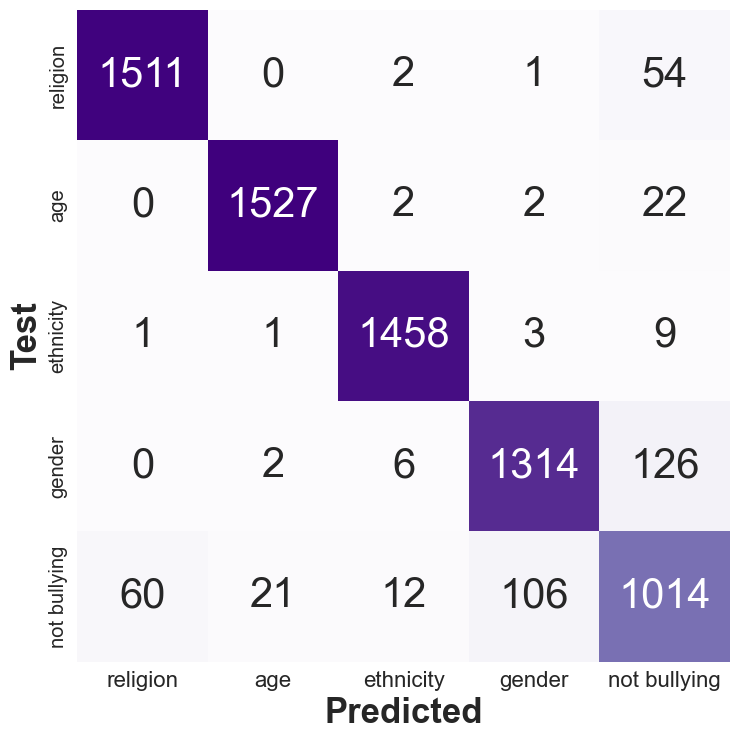

In [43]:
conf_matrix(y_test, bert_preds, labels)

# Examples

In [44]:
def print_predictions(X_test, y_test, y_pred, num_instances=5):
    for i in range(num_instances):
        text = X_test[i]
        true_label = labels[y_test[i]]
        predicted_label = labels[y_pred[i]]
        
        # Find the matching row in df based on the text value
        matching_row = df[df['text_clean'] == text]
        
        if not matching_row.empty:
            actual_text = matching_row['text'].iloc[0]
            actual_label = matching_row['label'].iloc[0]
            actual_label_text = labels[actual_label]
            
            print("Input Text:", actual_text)
            print("Actual Label:", actual_label_text)
            print("Predicted Label:", predicted_label)
            
            print("--------------")

print_predictions(X_test, y_test, bert_preds, num_instances=5)


Input Text: no one's laughing with you idiot. Just because a white girl called it a diet you continued to use it and fat-shame people? You call yourself a Muslim but can't even respect a person and the religion you follow.
Actual Label: religion
Predicted Label: religion
--------------
Input Text: @iRap4Food a little gift from me to you. If all male comedians you've seen are just making rape amd gay jokes. You found shit comedians. https://m.youtube.com/watch?v=YqdsNxS_fk8
Actual Label: gender
Predicted Label: gender
--------------
Input Text: The media. I agree. The dumb fucks are saying Nyjier not Niger.
Actual Label: ethnicity
Predicted Label: ethnicity
--------------
Input Text: You are about to be crucified by your own foolishness. The link you shared is to teach idiots like yourself about the sources from where concepts of laws were taken . Indian constitution doesn't have a special law for hindus.but there are laws specifically for muslims
Actual Label: religion
Predicted Label:

In [45]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Menghitung metrik evaluasi
accuracy = accuracy_score(y_test, bert_preds)
classification_rep = classification_report(y_test, bert_preds)
conf_matrix = confusion_matrix(y_test, bert_preds)

# Mencetak metrik evaluasi
print("Accuracy:", accuracy)
print("\nClassification Report:\n", classification_rep)
print("\nConfusion Matrix:\n", conf_matrix)


Accuracy: 0.9407223600771988

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.96      0.96      1568
           1       0.98      0.98      0.98      1553
           2       0.99      0.99      0.99      1472
           3       0.92      0.91      0.91      1448
           4       0.83      0.84      0.83      1213

    accuracy                           0.94      7254
   macro avg       0.94      0.94      0.94      7254
weighted avg       0.94      0.94      0.94      7254


Confusion Matrix:
 [[1511    0    2    1   54]
 [   0 1527    2    2   22]
 [   1    1 1458    3    9]
 [   0    2    6 1314  126]
 [  60   21   12  106 1014]]


In [46]:
# Identifikasi indeks dari prediksi yang salah
incorrect_indices = [i for i in range(len(y_test)) if y_test[i] != bert_preds[i]]

# Cetak contoh-contoh yang salah
for i in incorrect_indices:
    actual_label = labels[y_test[i]]
    predicted_label = labels[bert_preds[i]]
    print("Actual Label:", actual_label)
    print("Predicted Label:", predicted_label)
    print("Input Text:", X_test[i])
    print("--------------")


Actual Label: gender
Predicted Label: not bullying
Input Text: guess one bad mkr
--------------
Actual Label: not bullying
Predicted Label: age
Input Text: hate teacher cancel as fuckin class smfh
--------------
Actual Label: not bullying
Predicted Label: age
Input Text: workplace becomes new schoolyard bully bullying big problem adult workplace
--------------
Actual Label: not bullying
Predicted Label: gender
Input Text: rt guy feel entitled body treated basic human decency deep capacity
--------------
Actual Label: not bullying
Predicted Label: age
Input Text: wait wait waiti never see poorer excuse ta drop outta school bullyinglike say back homesmady hit yuhhit dem kissmeass back
--------------
Actual Label: gender
Predicted Label: not bullying
Input Text: one got beat acc lol bully haha xx
--------------
Actual Label: not bullying
Predicted Label: ethnicity
Input Text: yes given one group routinely post mutilated body twitter along american passport would say worse
--------------
A